In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import json
from scipy.spatial.transform import Rotation
from sbi import utils as utils
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis as analysis

In [3]:
config = json.load(open("config_square.json"))

image_params = dict(config["IMAGES"])
simulation_params = config["SIMULATION"]
training_params = dict(config["TRAINING"])

models = np.transpose(
    np.load(simulation_params["MODEL_FILE"]).diagonal(), [2, 0, 1]
)

In [4]:
def gen_quat():
    # Sonya's code
    # Generates a single quaternion

    count = 0
    while count < 1:

        quat = np.random.uniform(
            -1, 1, 4
        )  # note this is a half-open interval, so 1 is not included but -1 is
        norm = 1 / np.sqrt(np.sum(quat**2))

        if 0.2 <= norm <= 1.0:
            quat *= norm
            count += 1

    return quat


def gen_img(coord):

    n_atoms = coord.shape[1]
    norm = 1 / (2 * np.pi * image_params["SIGMA"] ** 2 * n_atoms)

    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = np.arange(grid_min, grid_max, image_params["PIXEL_SIZE"])

    gauss = np.exp(
        -0.5 * (((grid[:, None] - coord[0, :]) / image_params["SIGMA"]) ** 2)
    )[:, None] * np.exp(
        -0.5 * (((grid[:, None] - coord[1, :]) / image_params["SIGMA"]) ** 2)
    )

    image = gauss.sum(axis=2) * norm

    return image


def add_noise(img):

    # mean_image = np.mean(img)
    std_image = np.std(img)

    mask = np.abs(img) > 0.5 * std_image

    signal_mean = np.mean(img[mask])
    signal_std = np.std(img[mask])

    noise_std = signal_std / np.sqrt(image_params["SNR"])
    noise = np.random.normal(loc=signal_mean, scale=noise_std, size=img.shape)

    img_noise = img + noise

    return img_noise

def gaussian_normalize_image(image):

    mean_img = np.mean(image)
    std_img = np.std(image)

    return (image - mean_img) / std_img


def min_max_normalize_image(image):

    max_img = np.max(image)
    min_img = np.min(image)

    return (image - min_img) / (max_img - min_img)


def simulator(index):

    index = int(torch.round(index))

    coord = models[index]

    quat = gen_quat()
    rot_mat = Rotation.from_quat(quat).as_matrix()
    coord = np.matmul(rot_mat, coord)

    image = gen_img(coord)
    image = add_noise(image)
    image = gaussian_normalize_image(image)

    image = torch.tensor(image.reshape(-1, 1), device=training_params["DEVICE"])

    return image

prior_indices = utils.BoxUniform(
        low=0 * torch.ones(1, device=training_params["DEVICE"]),
        high=19 * torch.ones(1, device=training_params["DEVICE"]),
        device=training_params["DEVICE"],
    )

simulator_sbi, prior_sbi = prepare_for_sbi(simulator, prior_indices)

In [65]:
with open("posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [27]:
import torch.distributions as D

mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.tensor([7., 14.]), torch.tensor([2., 2.]))
gmm = D.MixtureSameFamily(mix, comp)



In [48]:
true_indices = gmm.sample((1000,))
true_indices = torch.round(true_indices)

true_indices = true_indices[true_indices <= 19]
true_indices = true_indices[true_indices >= 0]

true_indices = true_indices.numpy().flatten()

In [66]:
n_samples = 1000
n_indices = true_indices.shape[0]
samples = torch.empty(n_indices, n_samples, 1)

for i in range(n_indices):
    true_index = torch.tensor([[true_indices[i]]])
    true_image = simulator_sbi(true_index)
    samples[i] = posterior.sample((n_samples,), x=true_image, show_progress_bars=False)  

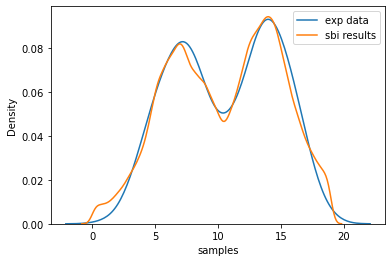

In [76]:
import pandas as pd
import seaborn as sns

obs = pd.DataFrame()
calc = pd.DataFrame()

obs["samples"] = true_indices.flatten()
calc["samples"] = samples.numpy().flatten()

sns.kdeplot(data=obs, x="samples", label="exp data")
sns.kdeplot(data=calc, x="samples", label="sbi results")

plt.legend()